# Тематическая классификация длинных текстов - TFIDF и LogReg

In [8]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/trex18/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.


In [42]:
%reload_ext autoreload

In [43]:
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, ngramize_corpus, \
    build_vocabulary, vectorize_texts, SparseFeaturesDataset, document_word_occurences, pmi, \
    informativeness
#from dlnlputils.data.bag_of_words import informativeness
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

## Предобработка текстов и подготовка признаков

In [2]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [3]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [9]:
train_ngrams = ngramize_corpus(train_source['data'], 2)
test_ngrams = ngramize_corpus(test_source['data'], 2)

In [31]:
MAX_DF = 0.8
MIN_COUNT = 5
#vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
vocabulary, word_doc_freq = build_vocabulary(train_ngrams, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 49536
[(('nntp', 'posting'), 0), (('posting', 'host'), 1), (('lines', 'article'), 2), (('organization', 'university'), 3), (('lines', 'nntp'), 4), (('have', 'been'), 5), (('writes', 'article'), 6), (('distribution', 'world'), 7), (('that', 'they'), 8), (('lines', 'distribution'), 9)]


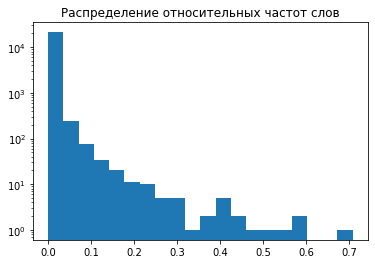

In [30]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [33]:
VECTORIZATION_MODE = 'tfidf'
"""
train_vectors, scaling_params = vectorize_texts(
    train_tokenized, vocabulary, word_doc_freq, 'train', 
    mode=VECTORIZATION_MODE, memorize_shifts=True
)
test_vectors, _ = vectorize_texts(
    test_tokenized, vocabulary, word_doc_freq, 'test',  
    mode=VECTORIZATION_MODE, memorize_shifts=True, scaling_params=scaling_params
)
"""

train_vectors, scaling_params = vectorize_texts(
    train_ngrams, vocabulary, word_doc_freq, 'train', 
    mode=VECTORIZATION_MODE, memorize_shifts=False
)
test_vectors, _ = vectorize_texts(
    test_ngrams, vocabulary, word_doc_freq, 'test',  
    mode=VECTORIZATION_MODE, memorize_shifts=False
)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', train_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в обучающей выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 49536)
Размерность матрицы признаков тестовой выборки (11314, 49536)

Количество ненулевых элементов в обучающей выборке 611304
Процент заполненности матрицы признаков 0.11%

Количество ненулевых элементов в обучающей выборке 318428
Процент заполненности матрицы признаков 0.09%


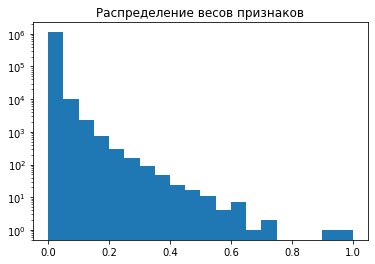

In [7]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [8]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


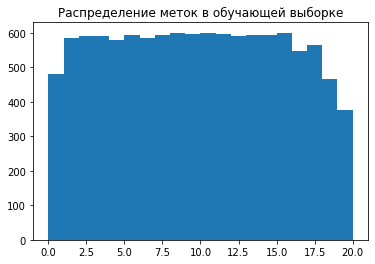

In [9]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

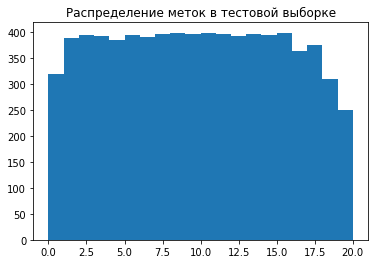

In [10]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

In [11]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [12]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(
    model=model,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    criterion=F.cross_entropy,
    lr=1e-1,
    epoch_n=200,
    batch_size=32,
    l2_reg_alpha=0,
    lr_scheduler_ctor=scheduler,
    l1_regularize=True,
    l1_reg_alpha=1e-5
)

Эпоха 0
Эпоха: 354 итераций, 6.61 сек
Среднее значение функции потерь на обучении 3.115354980452586
Среднее значение функции потерь на валидации 2.7816935413974826
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 6.25 сек
Среднее значение функции потерь на обучении 2.9769568881072566
Досрочно остановлено пользователем


## Оценка качества

In [21]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

354it [00:02, 155.37it/s]                              
  7%|▋         | 16/235.375 [00:00<00:01, 152.59it/s]

Среднее значение функции потерь на обучении 0.0041749742813408375
Доля верных ответов 0.9992929114371575



236it [00:01, 153.93it/s]                             

Среднее значение функции потерь на валидации 0.9288860559463501
Доля верных ответов 0.7712426978226234


## С использованием взаимной информации

In [31]:
doc_word_occurs = document_word_occurences(train_tokenized, vocabulary, train_source['target'], 20)
pmi_1, pmi_2 = pmi(doc_word_occurs.todense(), train_source['target'])

In [32]:
inf = informativeness(pmi_1, pmi_2)

In [56]:
VECTORIZATION_MODE = 'pmi'
train_vectors = vectorize_texts_pmi(
    train_tokenized, vocabulary, word_doc_freq, 
    mode=VECTORIZATION_MODE, scale=True, inf_vector=inf
)

In [59]:
test_vectors = vectorize_texts_pmi(
    test_tokenized, vocabulary, word_doc_freq, 
    mode=VECTORIZATION_MODE, scale=True, inf_vector=inf
)

# Альтернативная реализация на scikit-learn

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [23]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.495478891857855
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.653902258233705
Доля верных ответов 0.8190387679235263


# Результаты

| метод взвешивания | коэф l2_reg_alpha | коэф l1_reg_alpha | n_epochs | train accuracy | test accuracy | train error | test error |
|-------------------|-------------------|-------------------|----------|----------------|---------------|-------------|------------|
| tfidf             | 0                 | 0                 | 24       | 0.999          | 0.77          | 0.019       | 0.890      |
| tfidf             | 0.1               | 0                 | 49       | 0.053          | 0.053         | 2.992       | 2.992      |
| tfidf             | 2e-5              | 0                 | 33       | 0.61           | 0.41          | 2.75        | 2.86       |
| tfidf             | 1e-5              | 0                 | 50       | 0.779          | 0.523         | 2.55        | 2.76       |
| tfidf             | 2e-6              | 0                 | 28       | 0.916          | 0.656         | 1.71        | 2.28       |
| tfidf             | 1e-6              | 0                 | 29       | 0.946          | 0.669         | 1.27        | 2.01       |
| tfidf             | 1e-7              | 0                 | 24       | 0.995          | 0.746         | 0.32        | 1.32       |
| tfidf             | 0                 | 1e-5              | 80       | 0.868          | 0.495         | 1.15        | 1.86       |
| tfidf             | 0                 | 1e-6              | 35       | 0.993          | 0.76          | 0.2         | 1.16       |
| tfidf             | 0                 | 3e-6              | 67       | 0.975          | 0.742         | 0.41        | 1.35       |
| tfidf             | 0                 | 6e-6              | 354      | 0.935          | 0.722         | 0.74        | 1.57       |